# Principal Coordinate Analysis (PCA)

## Overview

PCA is the most well-known algorithm for the dimensionality reduction of datasets. It is a unsupervised learning method and transforms a higher dimensional dataset into a lower one with the goal of perserving as much information as possible. In PCA we want to map the set of $N$ data points where each data point $X_j = (x_{j1}, x_{j2}, x_{j3}, ..., x_{ND})$ exists in the space $\mathbb{R}^{D}$ with $D$ number of dimensions to the set of points where $\mathcal{X_j} = (\mathcal{X_{j1}}, \mathcal{X_{j2}}, \mathcal{X_{j3}}, ..., \mathcal{X}_{NK})$ in $\mathbb{R}^{K}$ where $K<D$. We can signifcately reduce the storage size of a dataset without major information loss using PCA. The transformation from $X_{jk}$ to $\mathcal{X}_{jk}$ is given by,

$$\mathcal{X}_{jk} = \mathbf{P}_k^{T} X_{jk}$$

$\mathbf{P}_k$ are our principal components which are linear combinations of our original features $x_{j1}$, $x_{j2}$, $x_{j3}$, etc. To determine our principle components, we must solve the following eigenvalue equation,

$$\Sigma \mathbf{P}_k = \lambda_k \mathbf{P}_k$$

In which, $\Sigma$ represents the covariance matrix, $\mathbf{P}_k$ is the $k$-th principal component and $\lambda_k$ is its corresponding eigenvalue. The elements of the covariance matrix are given by, 

$$ \Sigma_{\mu \nu} = \frac{1}{N} \sum^{N}_{i=j} (x_{j\mu} - \langle x_{\mu} \rangle)^T (x_{j\nu} - \langle x_{\nu} \rangle)$$

$\mu$ and $\nu$ are indices that index features of the original dataset. Therefore, $\Sigma$ is a square matrix with the dimensions $[D \times D]$. In solving this equation one will find that there are $D$ number of eigenvalues for the same number of principal components which satisfy,

$$\lambda_1 > \lambda_2 > ... > \lambda_k > ... > \lambda_D$$

In PCA, we choose how may dimensions we want the reduced dataset to have. Hence, if we want to reduce the dataset down to $K$ dimesions, we selected the $K$ largest eigenvalues $\lambda$ and their respective principal components (eigenvectors). This is in essence, the PCA algorithm. However, the mathematically steps required to produce these results requires many moving parts so to say. In other words, deriving PCA from first principles is mathematically rich. From a high-level view, PCA makes the assumption that information loss is minimised when the variance between the projected points from the higher dimensional space (our original dataset) to the lower dimensional space (transformed dataset) is maximised. A spread of values implies that there has been minimial compression and information loss. A deriviation of PCA from first principles in provided in the final section of this notebook.



## Implementation 

A Python implementation of PCA is very straight-forward using the functionality of NumPy. The construction of the covariance matrix $\Sigma$ and the solving of the eigenvalue equation $\Sigma \mathbf{P}_k = \lambda_k \mathbf{P}_k$ is made almost trivial,

In [183]:
# Imports,
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

class PCA():

    def __init__(self, n_components=None):
        """Constructor method. We create our class variables here."""

        # Assigning parameters as class variables,
        self.n_components = n_components

        # Creating placeholders for class attributes,
        self.means, self.cov_matrix, self.eigenvectors, self.eigenvalues, self.X = None, None, None, None, None
        self.X, self.N = None, None

    def fit(self, X):

        # Assigning to class variables,
        self.X, self.N = X, X.shape[0]
        if self.n_components is None:
            self.n_components = X.shape[1]

        # Constructing covariance matrix,
        self.cov_matrix = self.compute_cov_matrix(X)

        # Solving eigenvalue equation,
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.cov_matrix)

        # Sorting eigenvalues,
        sorted_idxs = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues, self.eigenvectors = self.eigenvalues[sorted_idxs], self.eigenvectors[sorted_idxs]

        # Applying the transformation to our original dataset,
        X_projected = np.dot(self.X, self.eigenvectors[:self.n_components].T)

        # Extracting our relevent principal components,
        prin_components = self.eigenvectors[:self.n_components]

        # Returning the relevent principle components,
        return prin_components, X_projected

    def compute_cov_matrix(self, X):

        # Subtracting mean,
        X_centered = X - np.mean(X, axis=0)

        # Appplying formula,
        cov_matrix = np.matmul(X_centered.T, X_centered)/self.N

        return cov_matrix
    
    def compute_var_ratios(self):
        
        # Computing the variance ratio of each component,
        ratios = self.eigenvalues/np.sum(self.eigenvalues)

        return ratios[:self.n_components]
    
    def compute_compression_ratio(self):

        # Number of dimensions in original and reduced datasets,
        N, D, K = self.X.shape[0], self.X.shape[1], self.n_components

        # Computing compression ratio,
        c_ratio = 1 - (K*(N + D)/(N*D))

        return c_ratio

Ideally, I would have liked to have created an algorithm to solve the eigenvalue equation from scratch. However, that is both off-topic and out-of-scope. Nevertheless, We perform PCA on the Iris dataset and reduce its dimensionality,

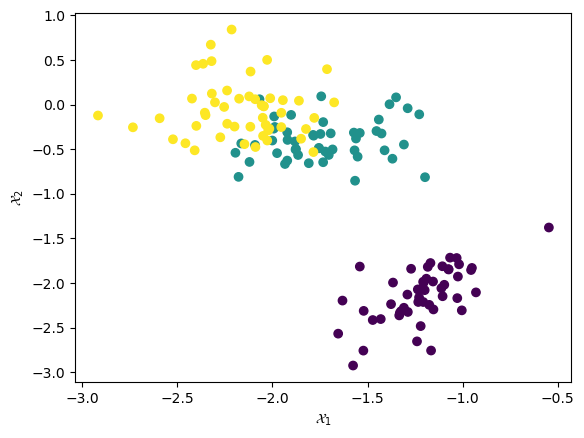

In [184]:
# Loading dataset,
dataset = load_iris()
X, y = dataset["data"], dataset["target"]

# Performing PCA,
pca = PCA(n_components=2)
components, X_trans = pca.fit(X)

# Plotting,
plt.scatter(X_trans.T[0], X_trans.T[1], c=y)
plt.xlabel(r"$\mathcal{X}_1$")
plt.ylabel(r"$\mathcal{X}_2$")
plt.show()

But how do we know the number of dimensions we want to reduce the dataset to? Recall that each principle component $\mathbf{P}_k$ has an associated eigenvalue $\lambda_k$. These eigenvalues represent the amount of variance in the data explained by their respective principal components. Hence, we can work out the proportion of the total variance explained by the 
$j$-th principal component $\mathbf{P}_k$ via,

$$F_k = \frac{\lambda_k}{\sum_{j=1}^{N} \lambda_k}$$

where $F_k$ is referred to as the variance ratio. The total variance ratio is then the following cummulative sum,

$$F(k) = \sum_{k=1}^{K} F_k = \frac{\sum_{k=1}^{K} \lambda_k}{\sum_{j=1}^{N} \lambda_k}$$

In which, $K$ is the number of dimensions (principal components) in the reduced dataset. Let us apply this form of component analysis to the MiceProtein dataset on OpenML: https://www.openml.org/search?type=data&id=4550&sort=runs&status=active which contains the expression levels of 77 proteins measured in the cerebral cortex of 8 classes of control and Down syndrome mice exposed to context fear conditioning. 

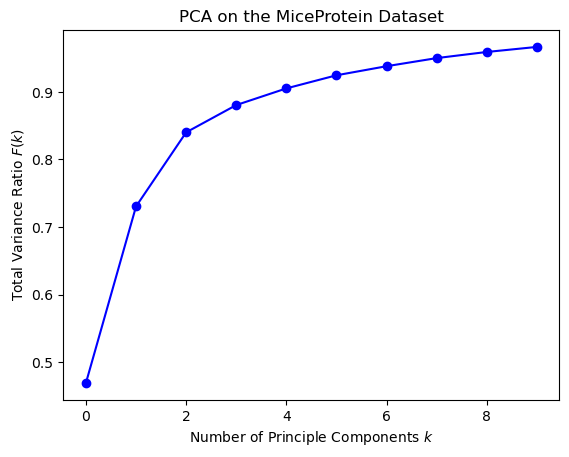

In [185]:
# Downloading dataset,
dataset = fetch_openml("miceprotein", version=4)  
X, y = dataset["data"], dataset["target"]

# Removing rows with empty values,
X = X.dropna()

# Performing PCA,
N_COMPONENTS = 10
pca = PCA(n_components=N_COMPONENTS)
components, X_trans = pca.fit(X)

# Component analysis,
ratios = pca.compute_var_ratios()
total_ratios = np.cumsum(ratios)

# Plotting,
plt.plot(total_ratios, marker="o", color="blue")
plt.title("PCA on the MiceProtein Dataset")
plt.xlabel("Number of Principle Components $k$")
plt.ylabel("Total Variance Ratio $F(k)$")
plt.show()

We find that only $K=10$ principles components is able to explain over 95% of the variance in the dataset. Finally to highlight the compression of the original dataset, we consider that $ND$ numbers are used represent the original dataset $X$ while $KD + KN = K(D+N)$ numbers are used construct the transformed dataset $\mathcal{X}$. With this in mind, we can define the compression ratio $\eta$ which is the proportion of storage saved by reducing the data from $D$ dimensions to $K$ principal components,

$$\eta = 1 - \frac{K(N + D)}{ND} = 1 - K \left( \frac{1}{D} + \frac{1}{N} \right)$$

When taking $K=10$ we find see $\eta \approx 0.85$, which means that PCA compressed 85% of the original dataset in storage size while retaining over 95% of its variance.   

In [186]:
compression_ratio = pca.compute_compression_ratio()
compression_ratio

0.8520139281008846

As a final note, we see that the compression ratio $\eta$ scales linearly with the number of principal components $K$.

## PCA From First Principles

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Morbi scelerisque sem a justo ultricies, quis efficitur justo dictum. Nunc vestibulum, tortor ut pellentesque imperdiet, mauris orci finibus ex, ac pretium urna diam in tellus. Vivamus non orci commodo, hendrerit ipsum in, tincidunt lorem. Cras vitae elit eu nibh tincidunt tristique. Integer convallis luctus eros imperdiet viverra. Mauris rhoncus accumsan lectus non maximus. Etiam finibus risus ipsum, eu vestibulum nulla pretium ac. Duis suscipit augue sit amet lectus efficitur convallis. Aenean luctus ipsum ut magna vulputate, eget fringilla tortor pharetra. Ut at lobortis orci. Fusce porttitor velit a tortor consequat efficitur. Maecenas vel sem orci.

## References

https://www.youtube.com/watch?v=X78tLBY3BMk

https://www.youtube.com/watch?v=dhK8nbtii6I

https://www.youtube.com/watch?v=pmG4K79DUoI

(https://www.youtube.com/watch?v=Rjr62b_h7S4)